# Homework 2 Exercise 2 - Hierarchical Probabilistic Model

Brennan McFarland  
bfm21

Suppose we are building a population model as part of a scientific study for determining the survival rate of different species on an island.  Let us suppose the island contains foxes, rabbits, birds, carrots and seeds, and we want to model the proportion of any such species surviving to reproduction.  Since foxes eat rabbits and birds, rabbits eat carrots and birds eat seeds, let's suppose the survival rate of each species is dependent on the survival rate of its respective predator and prey.

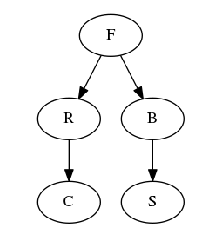

In [4]:
from graphviz import Digraph
import matplotlib.pyplot as plt
import matplotlib.image as imtool

image_format = 'png'
dot = Digraph(format=image_format)
dot.node('F', 'F')
dot.node('R', 'R')
dot.node('B', 'B')
dot.node('C', 'C')
dot.node('S', 'S')
dot.edges(['FR', 'FB', 'RC', 'BS'])
path = 'exercise2-graph'
dot.render(path)
imorg = imtool.imread(path + '.' + image_format)
plt.axis('off')
plt.imshow(imorg)

## Probabilities

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

p_f = .6
p_r = .2
p_b = .3
p_c = .1
p_s = .05

print("Suppose that, given our previous knowledge about similar populations, we have the following prior probabilities:")
print("P(F) = ", p_f)
print("P(R) = ", p_r)
print("P(B) = ", p_b)
print("P(C) = ", p_c)
print("P(S) = ", p_s)



print("And we make an educated guess about the continuous conditional probabilities:")
# TODO


Suppose that, given our previous knowledge about similar populations, we have the following prior probabilities:
P(F) =  0.6
P(R) =  0.2
P(B) =  0.3
P(C) =  0.1
P(S) =  0.05
And we make an educated guess about the continuous conditional probabilities:


Let us define the corresponding Probabilistic Model in PyMC3 as follows:

In [5]:
import pymc3
from pymc3 import Bernoulli
from pymc3 import Beta
from pymc3.math import switch

model = pymc3.Model()

# TODO: make sure these values actually make sense
with model:
    Foxes = Beta('Foxes', mu=(1-1/(p_r+p_b)), sd=.6)
    Rabbits = Beta('Rabbits', mu=(1-1/(1-p_c/p_f)), sd=.7)
    Carrots = Beta('Carrots', mu=(1-1/math.sqrt(p_r)), sd=.2)
    Seeds = Beta('Seeds', mu=(1-1/math.sqrt(p_b)), sd=.3)

(b) (using the same notebook) Use probability theory to derive a posterior distribution using
your previous example. Show this is consistent with what you obtain from the package.

## Sample Generation

In [6]:
%matplotlib inline
samples = 20000
with model:
    trace = pymc3.sample(samples, chains=2)
    pymc3.traceplot(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/user/.local/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Seeds_logodds__, Carrots_logodds__, Rabbits_logodds__, Foxes_logodds__]
  0%|          | 0/20500 [00:00<?, ?it/s]


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7fca52332f60, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/user/.local/lib/python3.5/site-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/user/.local/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/user/..../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7fca52332f60, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/user/.local/lib/python3.5/site-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/user/.local/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/user/..../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/user/.local/lib/python3.5/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/user/.local/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/user/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/user/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/user/.local/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/user/.local/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/user/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/user/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/user/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/user/.local/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/user/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/user/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '%matplotlib inline\nsamples = 20000\nwith model:\n ...ple(samples, chains=2)\n    pymc3.traceplot(trace)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 2, 17, 43, 48, 308984, tzinfo=tzutc()), 'msg_id': '34DA4A39FF5F4AF197C29BEAB7AE78C9', 'msg_type': 'execute_request', 'session': '0857DF68DFEF4E12940F063113602DA8', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '34DA4A39FF5F4AF197C29BEAB7AE78C9', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'0857DF68DFEF4E12940F063113602DA8']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '%matplotlib inline\nsamples = 20000\nwith model:\n ...ple(samples, chains=2)\n    pymc3.traceplot(trace)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 2, 17, 43, 48, 308984, tzinfo=tzutc()), 'msg_id': '34DA4A39FF5F4AF197C29BEAB7AE78C9', 'msg_type': 'execute_request', 'session': '0857DF68DFEF4E12940F063113602DA8', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '34DA4A39FF5F4AF197C29BEAB7AE78C9', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/user/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'0857DF68DFEF4E12940F063113602DA8'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '%matplotlib inline\nsamples = 20000\nwith model:\n ...ple(samples, chains=2)\n    pymc3.traceplot(trace)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 2, 17, 43, 48, 308984, tzinfo=tzutc()), 'msg_id': '34DA4A39FF5F4AF197C29BEAB7AE78C9', 'msg_type': 'execute_request', 'session': '0857DF68DFEF4E12940F063113602DA8', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '34DA4A39FF5F4AF197C29BEAB7AE78C9', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/user/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='%matplotlib inline\nsamples = 20000\nwith model:\n ...ple(samples, chains=2)\n    pymc3.traceplot(trace)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '%matplotlib inline\nsamples = 20000\nwith model:\n ...ple(samples, chains=2)\n    pymc3.traceplot(trace)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/user/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('%matplotlib inline\nsamples = 20000\nwith model:\n ...ple(samples, chains=2)\n    pymc3.traceplot(trace)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('%matplotlib inline\nsamples = 20000\nwith model:\n ...ple(samples, chains=2)\n    pymc3.traceplot(trace)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/user/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='%matplotlib inline\nsamples = 20000\nwith model:\n ...ple(samples, chains=2)\n    pymc3.traceplot(trace)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/home/user/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>, <_ast.Assign object>, <_ast.With object>], cell_name='<ipython-input-6-b86ecd7a7a89>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7fca0e6a40b8, executi..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fca0e8339c0, file "<ipython-input-6-b86ecd7a7a89>", line 3>
        result = <ExecutionResult object at 7fca0e6a40b8, executi..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/home/user/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fca0e8339c0, file "<ipython-input-6-b86ecd7a7a89>", line 3>, result=<ExecutionResult object at 7fca0e6a40b8, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fca0e8339c0, file "<ipython-input-6-b86ecd7a7a89>", line 3>
        self.user_global_ns = {'Bernoulli': <class 'pymc3.distributions.discrete.Bernoulli'>, 'Beta': <class 'pymc3.distributions.continuous.Beta'>, 'Carrots': Carrots, 'Foxes': Foxes, 'In': ['', "import pymc3\nfrom pymc3 import Bernoulli\nfrom py...s = Beta('Seeds', mu=(1-1/math.sqrt(p_b)), sd=.1)", "import pymc3\nfrom pymc3 import Bernoulli\nfrom py...s = Beta('Seeds', mu=(1-1/math.sqrt(p_b)), sd=.3)", 'import numpy as np\nimport matplotlib.pyplot as p...he continuous conditional probabilities:")\n# TODO', "import pymc3\nfrom pymc3 import Bernoulli\nfrom py...s = Beta('Seeds', mu=(1-1/math.sqrt(p_b)), sd=.3)", "import pymc3\nfrom pymc3 import Bernoulli\nfrom py...s = Beta('Seeds', mu=(1-1/math.sqrt(p_b)), sd=.3)", "get_ipython().run_line_magic('matplotlib', 'inli...ple(samples, chains=2)\n    pymc3.traceplot(trace)"], 'Out': {}, 'Rabbits': Rabbits, 'Seeds': Seeds, '_': '', '__': '', ...}
        self.user_ns = {'Bernoulli': <class 'pymc3.distributions.discrete.Bernoulli'>, 'Beta': <class 'pymc3.distributions.continuous.Beta'>, 'Carrots': Carrots, 'Foxes': Foxes, 'In': ['', "import pymc3\nfrom pymc3 import Bernoulli\nfrom py...s = Beta('Seeds', mu=(1-1/math.sqrt(p_b)), sd=.1)", "import pymc3\nfrom pymc3 import Bernoulli\nfrom py...s = Beta('Seeds', mu=(1-1/math.sqrt(p_b)), sd=.3)", 'import numpy as np\nimport matplotlib.pyplot as p...he continuous conditional probabilities:")\n# TODO', "import pymc3\nfrom pymc3 import Bernoulli\nfrom py...s = Beta('Seeds', mu=(1-1/math.sqrt(p_b)), sd=.3)", "import pymc3\nfrom pymc3 import Bernoulli\nfrom py...s = Beta('Seeds', mu=(1-1/math.sqrt(p_b)), sd=.3)", "get_ipython().run_line_magic('matplotlib', 'inli...ple(samples, chains=2)\n    pymc3.traceplot(trace)"], 'Out': {}, 'Rabbits': Rabbits, 'Seeds': Seeds, '_': '', '__': '', ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/user/Repositories/ainotebooks/<ipython-input-6-b86ecd7a7a89> in <module>()
      1 get_ipython().run_line_magic('matplotlib', 'inline')
      2 samples = 20000
      3 with model:
----> 4     trace = pymc3.sample(samples, chains=2)
      5     pymc3.traceplot(trace)

...........................................................................
/home/user/.local/lib/python3.5/site-packages/pymc3/sampling.py in sample(draws=20500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, init='auto', n_init=200000, start=[{'Carrots_logodds__': array(nan), 'Foxes_logodds__': array(nan), 'Rabbits_logodds__': array(nan), 'Seeds_logodds__': array(nan)}, {'Carrots_logodds__': array(nan), 'Foxes_logodds__': array(nan), 'Rabbits_logodds__': array(nan), 'Seeds_logodds__': array(nan)}], trace=None, chain_idx=0, chains=2, njobs=2, tune=500, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=[486367480, 371563062], live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, compute_convergence_checks=True, **kwargs={})
    414     parallel = njobs > 1 and chains > 1 and not has_population_samplers
    415     if parallel:
    416         _log.info('Multiprocess sampling ({} chains in {} jobs)'.format(chains, njobs))
    417         _print_step_hierarchy(step)
    418         try:
--> 419             trace = _mp_sample(**sample_args)
        trace = None
        sample_args = {'chain': 0, 'chains': 2, 'draws': 20500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'njobs': 2, 'progressbar': True, 'random_seed': [486367480, 371563062], 'start': [{'Carrots_logodds__': array(nan), 'Foxes_logodds__': array(nan), 'Rabbits_logodds__': array(nan), 'Seeds_logodds__': array(nan)}, {'Carrots_logodds__': array(nan), 'Foxes_logodds__': array(nan), 'Rabbits_logodds__': array(nan), 'Seeds_logodds__': array(nan)}], ...}
    420         except pickle.PickleError:
    421             _log.warn("Could not pickle model, sampling singlethreaded.")
    422             _log.debug('Pickling error:', exec_info=True)
    423             parallel = False

...........................................................................
/home/user/.local/lib/python3.5/site-packages/pymc3/sampling.py in _mp_sample(**kwargs={'draws': 20500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500})
    944 
    945     chain_nums = list(range(chain, chain + chains))
    946     pbars = [kwargs.pop('progressbar')] + [False] * (chains - 1)
    947     jobs = (delayed(_sample)(*args, **kwargs)
    948             for args in zip(chain_nums, pbars, rseed, start))
--> 949     traces = Parallel(n_jobs=njobs)(jobs)
        traces = undefined
        njobs = 2
        jobs = <generator object _mp_sample.<locals>.<genexpr>>
    950     return MultiTrace(traces)
    951 
    952 
    953 def stop_tuning(step):

...........................................................................
/home/user/.local/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object _mp_sample.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Mar  2 12:43:52 2018
PID: 6838                                    Python 3.5.3: /usr/bin/python3
...........................................................................
/home/user/.local/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _sample>, (0, True, 486367480, {'Carrots_logodds__': array(nan), 'Foxes_logodds__': array(nan), 'Rabbits_logodds__': array(nan), 'Seeds_logodds__': array(nan)}), {'draws': 20500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/user/.local/lib/python3.5/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = (0, True, 486367480, {'Carrots_logodds__': array(nan), 'Foxes_logodds__': array(nan), 'Rabbits_logodds__': array(nan), 'Seeds_logodds__': array(nan)})
        kwargs = {'draws': 20500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/user/.local/lib/python3.5/site-packages/pymc3/sampling.py in _sample(chain=0, progressbar=True, random_seed=486367480, start={'Carrots_logodds__': array(nan), 'Foxes_logodds__': array(nan), 'Rabbits_logodds__': array(nan), 'Seeds_logodds__': array(nan)}, draws=20500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, trace=None, tune=500, model=<pymc3.model.Model object>, live_plot=False, live_plot_kwargs=None, **kwargs={})
    521                             tune, model, random_seed)
    522     if progressbar:
    523         sampling = tqdm(sampling, total=draws)
    524     try:
    525         strace = None
--> 526         for it, strace in enumerate(sampling):
        it = undefined
        strace = None
        sampling =   0%|          | 0/20500 [00:00<?, ?it/s]
    527             if live_plot:
    528                 if live_plot_kwargs is None:
    529                     live_plot_kwargs = {}
    530                 if it >= skip_first:

...........................................................................
/home/user/.local/lib/python3.5/site-packages/tqdm/_tqdm.py in __iter__(self=  0%|          | 0/20500 [00:00<?, ?it/s])
    950             except AttributeError:
    951                 raise TqdmDeprecationWarning("""\
    952 Please use `tqdm_gui(...)` instead of `tqdm(..., gui=True)`
    953 """, fp_write=getattr(self.fp, 'write', sys.stderr.write))
    954 
--> 955             for obj in iterable:
        obj = undefined
        iterable = <generator object _iter_sample>
    956                 yield obj
    957                 # Update and possibly print the progressbar.
    958                 # Note: does not call self.update(1) for speed optimisation.
    959                 n += 1

...........................................................................
/home/user/.local/lib/python3.5/site-packages/pymc3/sampling.py in _iter_sample(draws=20500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'Carrots_logodds__': array(nan), 'Foxes_logodds__': array(nan), 'Rabbits_logodds__': array(nan), 'Seeds_logodds__': array(nan)}, trace=None, chain=0, tune=500, model=<pymc3.model.Model object>, random_seed=486367480)
    619         step.tune = bool(tune)
    620         for i in range(draws):
    621             if i == tune:
    622                 step = stop_tuning(step)
    623             if step.generates_stats:
--> 624                 point, states = step.step(point)
        point = {'Carrots_logodds__': array(nan), 'Foxes_logodds__': array(nan), 'Rabbits_logodds__': array(nan), 'Seeds_logodds__': array(nan)}
        states = undefined
        step.step = <bound method GradientSharedStep.step of <pymc3.step_methods.hmc.nuts.NUTS object>>
    625                 if strace.supports_sampler_stats:
    626                     strace.record(point, states)
    627                 else:
    628                     strace.record(point)

...........................................................................
/home/user/.local/lib/python3.5/site-packages/pymc3/step_methods/arraystep.py in step(self=<pymc3.step_methods.hmc.nuts.NUTS object>, point={'Carrots_logodds__': array(nan), 'Foxes_logodds__': array(nan), 'Rabbits_logodds__': array(nan), 'Seeds_logodds__': array(nan)})
    217     def step(self, point):
    218         self._logp_dlogp_func.set_extra_values(point)
    219         array = self._logp_dlogp_func.dict_to_array(point)
    220 
    221         if self.generates_stats:
--> 222             apoint, stats = self.astep(array)
        apoint = undefined
        stats = undefined
        self.astep = <bound method BaseHMC.astep of <pymc3.step_methods.hmc.nuts.NUTS object>>
        array = array([nan, nan, nan, nan])
    223             point = self._logp_dlogp_func.array_to_full_dict(apoint)
    224             return point, stats
    225         else:
    226             apoint = self.astep(array)

...........................................................................
/home/user/.local/lib/python3.5/site-packages/pymc3/step_methods/hmc/base_hmc.py in astep(self=<pymc3.step_methods.hmc.nuts.NUTS object>, q0=array([nan, nan, nan, nan]))
    112         start = self.integrator.compute_state(q0, p0)
    113 
    114         if not np.isfinite(start.energy):
    115             self.potential.raise_ok()
    116             raise ValueError('Bad initial energy: %s. The model '
--> 117                              'might be misspecified.' % start.energy)
        start.energy = nan
    118 
    119         adapt_step = self.tune and self.adapt_step_size
    120         step_size = self.step_adapt.current(adapt_step)
    121         self.step_size = step_size

ValueError: Bad initial energy: nan. The model might be misspecified.
___________________________________________________________________________

## Posterior Inference

In [21]:
def conditional_probability(trace, event, cond):
    # find all samples satisfy conditions
    for k, v in cond.items():
        trace = [smp for smp in trace if smp[k] == v]
    # record quantity of all samples fulfill condition
    nCondSample = len(trace)
    # find all samples satisfy event
    for k, v in event.items():
        trace = [smp for smp in trace if smp[k] == v]
    # calculate conditional probability
    return len(trace) / nCondSample

Now say for example we want to calculate the survival rate of foxes based on the survival rate of carrots and seeds:

## Variable Elimination